In [40]:
import json
import os
import datasets
import tqdm
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
TRAIN_CONDITIONS = [100000, 10000, 3000]


In [41]:
# query and positives
full_ds = datasets.load_dataset(
    "miracl/miracl", "ja", use_auth_token=os.environ["HF_ACCESS_TOKEN"], split="dev"
)

# all corpus texts
full_corpus = datasets.load_dataset("miracl/miracl-corpus", "ja")

In [42]:
ds = full_ds

# make subset of corpus to reduce filtering time
positive_docids = set()
for item in ds:
    for pp in item["positive_passages"]:
        positive_docids.add(pp["docid"])

max_corpus_size = max(TRAIN_CONDITIONS)*2 + len(positive_docids)
corpus_without_positive = full_corpus["train"].select(range(max_corpus_size)).filter(lambda x: x["docid"] not in positive_docids)


In [43]:
mecab = MeCab.Tagger("-Owakati")

def tokenize_jp(text: str) -> str:
    tokens = mecab.parse(text).split()
    return tokens


In [44]:
# corpusというディレクトリを作る
OUTPUT_DIR = "output/experiment1"
os.makedirs(OUTPUT_DIR, exist_ok=True)
# train_corpusのtextをtokenizeしてdocidとともにjsonlで保存
corpus_without_positive_json = []
corpus_without_positive_path = f"{OUTPUT_DIR}/corpus_without_positive.json"

if os.path.exists(corpus_without_positive_path):
    with open(corpus_without_positive_path) as f:
        corpus_without_positive_json = json.load(f)
else:
    for doc in tqdm.tqdm(corpus_without_positive):
        corpus_without_positive_json.append({"docid": doc["docid"], "text": tokenize_jp(doc["text"])})
    with open(corpus_without_positive_path, "w") as f:
        json.dump(corpus_without_positive_json, f, ensure_ascii=False)

100%|██████████| 201694/201694 [01:13<00:00, 2743.23it/s]


In [45]:
full_vocabulary = set()

for doc in tqdm.tqdm(corpus_without_positive_json):
    full_vocabulary.update(doc["text"])
for item in tqdm.tqdm(ds):
    query_text = item["query"]
    query_text = tokenize_jp(query_text)
    full_vocabulary.update(query_text)
    for pp in item["positive_passages"]:
        pp_text = pp["text"]
        pp_text = tokenize_jp(pp_text)
        full_vocabulary.update(pp_text)

100%|██████████| 860/860 [00:01<00:00, 722.69it/s]


In [46]:
vectorizer_dict = {}
train_corpus = corpus_without_positive_json[:max(TRAIN_CONDITIONS)]

for train_condition in tqdm.tqdm(TRAIN_CONDITIONS):
    vectorizer = TfidfVectorizer(
        vocabulary=full_vocabulary
        , analyzer = lambda x: x
    )
    vectorizer.fit([doc["text"] for doc in train_corpus[:train_condition]])
    vectorizer_dict[f"train_{train_condition}"] = vectorizer

# TRAIN_CONDITION = 0のケース
vectorizer_dict[f"train_0"] = CountVectorizer(vocabulary=full_vocabulary, analyzer = lambda x: x)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/jiro/vscode/workspace/retriever-evaluation/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


In [47]:
positive_corpus_json = []
done_docids = set()
for item in tqdm.tqdm(ds):
    for pp in item["positive_passages"]:
        if pp["docid"] in done_docids:
            continue
        positive_corpus_json.append({
            "text": tokenize_jp(pp["text"]),
            "docid": pp["docid"]
        })

test_corpus = positive_corpus_json + corpus_without_positive_json[max(TRAIN_CONDITIONS):max(TRAIN_CONDITIONS)*2]

for test_condition in tqdm.tqdm(TRAIN_CONDITIONS):
    vectorizer = TfidfVectorizer(vocabulary=full_vocabulary, analyzer=lambda x: x)
    vectorizer.fit([doc["text"] for doc in test_corpus[:test_condition]])
    vectorizer_dict[f"test_{test_condition}"] = vectorizer

100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


In [48]:
if os.path.exists(f"{OUTPUT_DIR}/rank_dict.json"):
    with open(f"{OUTPUT_DIR}/rank_dict.json") as f:
        rank_dict = json.load(f)
else:
    rank_dict = {}
    query_texts = [tokenize_jp(query["query"]) for query in ds]

    def calc_result(test_corpus, vectorizer):
        global query_texts, ds
        
        test_matrix = vectorizer.transform([doc["text"] for doc in test_corpus])
        query_matrix = vectorizer.transform(query_texts)

        # 類似度行列を計算し、queryのdocidのランクを取得
        similarity_matrix = cosine_similarity(query_matrix, test_matrix)
        ranking_matrix = np.argsort(similarity_matrix, axis=1)[:, ::-1]

        test_docid2indice = {item["docid"]: i for i, item in enumerate(test_corpus)}    

        query_result = []
        for item, ranking in zip(ds, ranking_matrix):
            # rankingの何番目にdocidがあるかを取得
            docids = [pp["docid"] for pp in item["positive_passages"]]
            docid_indices = [test_docid2indice[docid] for docid in docids if docid in test_docid2indice]
            ranks = [list(ranking).index(docid_index) for docid_index in docid_indices]
            query_result.append({
                "query_id": item["query_id"],
                "ranks": ranks
            })
        return query_result

    #for test_condition in tqdm.tqdm(TEST_CONDITIONS):
    for test_condition in tqdm.tqdm(TRAIN_CONDITIONS):

        # train_vectorizer
        keyname = f"train_{test_condition}"
        vectorizer = vectorizer_dict[keyname]
        result = calc_result(test_corpus[:test_condition], vectorizer)
        rank_dict[f"{keyname}_test_{test_condition}"] = result

        # test_vectorizer
        keyname = f"test_{test_condition}"
        vectorizer = vectorizer_dict[keyname]
        result = calc_result(test_corpus[:test_condition], vectorizer)
        rank_dict[f"{keyname}_test_{test_condition}"] = result

        # count_vectorizer
        keyname = f"train_0"
        vectorizer = vectorizer_dict[keyname]
        result = calc_result(test_corpus[:test_condition], vectorizer)
        rank_dict[f"{keyname}_test_{test_condition}"] = result

    with open(f"{OUTPUT_DIR}/rank_dict.json", "w") as f:
        json.dump(rank_dict, f, ensure_ascii=False)


100%|██████████| 3/3 [02:25<00:00, 48.42s/it] 


In [49]:
ns = [1, 3, 5, 10, 30, 100]
rows = []    
for keyname, ranks in rank_dict.items():
    row = {"keyname": keyname}
    for n in ns:
        recall = 0
        for rank in ranks:
            recall += sum([1 if r < n else 0 for r in rank["ranks"]]) / len(rank["ranks"])
        recall /= len(ranks)
        #print(keyname, n, recall)
        row[f"recall@{n}"] = recall
    rows.append(row)
df = pd.DataFrame(rows)
df.to_csv(f"{OUTPUT_DIR}/result.csv", index=False)
print(df)


                    keyname  recall@1  recall@3  recall@5  recall@10  \
0  train_100000_test_100000  0.278682  0.473031  0.552143   0.642019   
1   test_100000_test_100000  0.276463  0.463881  0.543175   0.636757   
2       train_0_test_100000  0.050403  0.088943  0.112385   0.136940   
3    train_10000_test_10000  0.421941  0.648099  0.736269   0.813614   
4     test_10000_test_10000  0.417066  0.641006  0.729451   0.808226   
5        train_0_test_10000  0.102448  0.180953  0.208894   0.256381   
6      train_3000_test_3000  0.445265  0.698564  0.787850   0.857891   
7       test_3000_test_3000  0.451961  0.702595  0.784082   0.857100   
8         train_0_test_3000  0.129065  0.216113  0.255414   0.312784   

   recall@30  recall@100  
0   0.759830    0.837303  
1   0.755813    0.836410  
2   0.182717    0.257245  
3   0.883225    0.920221  
4   0.881255    0.921481  
5   0.343419    0.475493  
6   0.910396    0.944419  
7   0.909718    0.945775  
8   0.437882    0.585221  


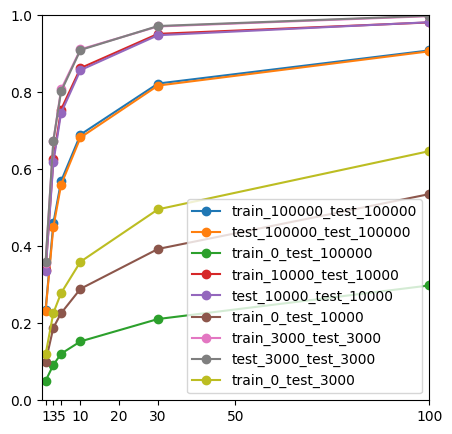

In [50]:
# rank_dictを折れ線グラフにする。縦軸がrecall、横軸がrecall_at、線がkeyname
import matplotlib.pyplot as plt
# 画像のサイズを指定
plt.figure(figsize=(5, 5))
# 縦軸の範囲を指定
plt.ylim(0, 1)
# 横軸の範囲を指定
plt.xlim(0, 100)
# 横軸の目盛りを指定
plt.xticks([1, 3, 5, 10, 20, 30, 50, 100])
# 縦軸の目盛りを指定
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# グラフの描画。
for keyname, ranks in rank_dict.items():
    recall_list = []
    for n in ns:
        recall = 0
        for rank in ranks:
            recall += sum([1 if r < n else 0 for r in rank["ranks"]]) / len(rank)
        recall /= len(ranks)
        recall_list.append(recall)
    plt.plot(ns, recall_list, label=keyname, marker="o")
# 凡例の表示
plt.legend()
# グラフの表示
plt.show()
